In [236]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [237]:
class World:
    def __init__(self, N, M, car_dim):
        self.N = N
        self.M = M
        self.car_width, self.car_length = car_dim

        self.stops = self.generate_stops()
    
    def generate_stops(self):
        x = np.arange(self.car_width/2, self.N, self.car_width)
        y = np.arange(self.car_width/2, self.M, self.car_width)
        stops = [(i, j) for j in y for i in x]
        return stops

    def plot(self):
        fig = plt.figure(figsize=(self.N, self.M))
        ax = fig.add_subplot(111)

        # plot contours
        ax.plot([0, self.N], [0, 0], c='b')
        ax.plot([0, self.N], [self.M, self.M], c='b')
        ax.plot([0, 0], [0, self.M], c='b')
        ax.plot([self.N, self.N], [0, self.M], c='b')

        # plot stops
        ax.scatter(*zip(*self.stops))

        # plot car
        ax.plot([0, self.car_width], [0, 0], c='r')
        ax.plot([0, self.car_width], [self.car_length, self.car_length], c='r')
        ax.plot([0, 0], [0, self.car_length], c='r')
        ax.plot([self.car_width, self.car_width], [0, self.car_length], c='r')

        plt.show()


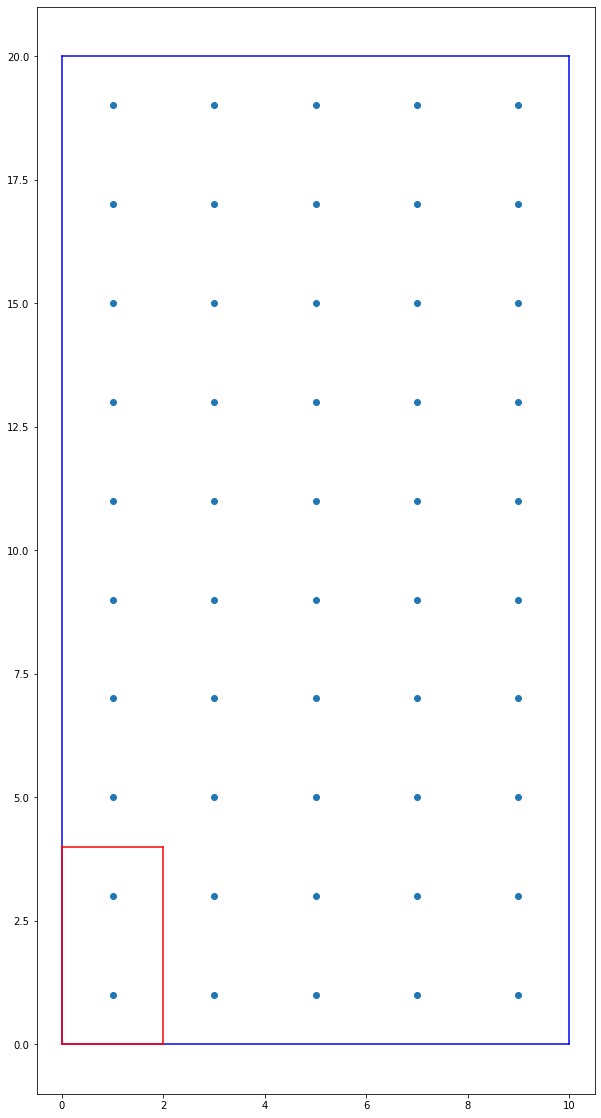

In [238]:
world = World(10, 20, (2, 4))
world.plot()

In [239]:
class TSP:
    def __init__(self, world, epsilon=0.5, epsilon_min=0.01, epsilon_decay=0.9, gamma=0.95, learning_rate=0.95):
        self.world = world
        self.stops = self.world.stops
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.learning_rate = learning_rate        

        self.Q = self.init_Q()
        self.coord2state = self.init_coord2state()
        self.state2coord = self.init_state2coord()

        self.n_states = len(self.coord2state)

    def init_Q(self):
        Q = cdist(self.stops, self.stops, 'euclidean')
        return Q

    def init_coord2state(self):
        coord2state = {}
        for i, stop in enumerate(self.stops):
            coord2state[stop] = i
        return coord2state

    def init_state2coord(self):
        state2coord = {}
        for i, stop in enumerate(self.stops):
            state2coord[i] = stop
        return state2coord

    def train(self, s, a, r, s_next):
        self.Q[s,a] = self.Q[s,a] + self.learning_rate * (r + self.gamma * np.max(self.Q[s_next,a]) - self.Q[s,a])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def act_eps_greedy(self, s):
        q = np.copy(self.Q[s,:])
        q[self.visited] = -np.inf

        if np.random.rand() < self.epsilon:
            a = np.random.choice([act for act in range(self.n_states) if act not in self.visited])
        else:
            a = np.argmax(q)
        return a
    
    def reset(self):
        self.path = []
        self.visited = []
        first_stop = np.random.randint(self.n_states)
        self.visited.append(first_stop)
        self.path.append(first_stop)
        return first_stop
    
    def transition(self, s, a):
        s_next = a
        reward = self.get_reward(s, s_next)
        self.path.append(s_next)
        self.visited.append(s_next)
        done = len(self.path) == self.n_states
        return s_next, reward, done

    def get_reward(self, s, s_next):
        reward = self.Q[s,s_next]
        return reward

    def run_episode(self):
        s = self.reset()
        max_steps = self.n_states
        episode_reward = 0

        for _ in range(max_steps):
            a = self.act_eps_greedy(s)
            s1, r, done = self.transition(s,a)
            r *= -1
            self.train(s, a, r, s1)
            episode_reward += r
            s = s1

            if done:
                break
        return episode_reward

    def render(self):
        fig = plt.figure(figsize=(self.world.N, self.world.M))
        ax = fig.add_subplot(111)

        # plot contours
        ax.plot([0, self.world.N], [0, 0], c='b')
        ax.plot([0, self.world.N], [self.world.M, self.world.M], c='b')
        ax.plot([0, 0], [0, self.world.M], c='b')
        ax.plot([self.world.N, self.world.N], [0, self.world.M], c='b')

        # plot stops
        ax.scatter(*zip(*self.world.stops))

        # plot path
        for i in range(len(self.path)-1):
            s0, s1 = self.path[i], self.path[i+1]
            x0, y0 = self.state2coord[s0]
            x1, y1 = self.state2coord[s1]
            ax.arrow(x0, y0, (x1-x0), (y1-y0), width=0.005, head_width=0.001, color="r")


        # plot car
        ax.plot([0, self.world.car_width], [0, 0], c='r')
        ax.plot([0, self.world.car_width], [self.world.car_length, self.world.car_length], c='r')
        ax.plot([0, 0], [0, self.world.car_length], c='r')
        ax.plot([self.world.car_width, self.world.car_width], [0, self.world.car_length], c='r')

        plt.show()
    

Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1502.62it/s]


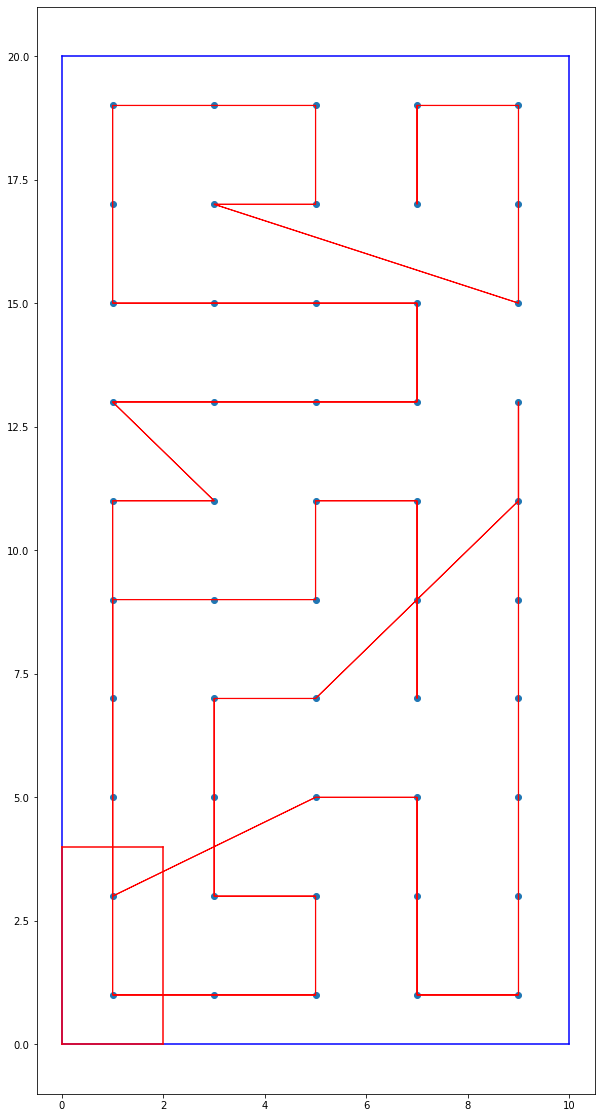

In [240]:
tsp = TSP(world)
reward_list = []
for _ in tqdm(range(1000), desc='Episodes'):
    reward = tsp.run_episode()
    reward_list.append(reward)
tsp.render()


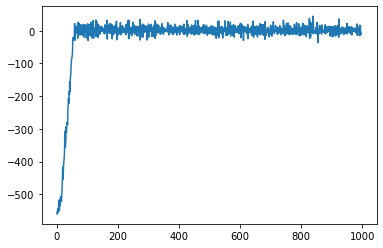

In [241]:
plt.figure()
plt.plot(reward_list[2:])
plt.show()

In [7]:
import numpy as np
x = np.arange(2, 30, 2)
x = x[:-1]
x

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26])